# Twitter Sentiment Analysis

Name: Faris Chaudhry

Country: United Kingdom

Email: faris.chaudhry@outlook.com

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec

from textblob import TextBlob
from textblob import Word
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

## Helper Functions

In [5]:
# Average word length (rounded to 3 dp)
def avg_word_length(sentence):
    words = sentence.split()
    return round((sum(len(word) for word in words)/float(len(words))), 3)

## Dataframes

In [6]:
traindata_filepath = "train_tweets.csv"
testdata_filepath = "test_tweets.csv"

In [7]:
train_df = pd.read_csv(traindata_filepath, index_col=0)
test_df = pd.read_csv(testdata_filepath, index_col=0)
train_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17197 entries, 31963 to 49159
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 268.7+ KB


## Validation

In [10]:
# Standardise column names
train_df.columns = list(map(lambda x: x.strip('_').lower(), list(train_df.columns)))
test_df.columns = list(map(lambda x: x.strip('_').lower(), list(test_df.columns)))

# Remove duplicate tweets
train_df.drop_duplicates(subset=['tweet'], keep='last', inplace=True)
test_df.drop_duplicates(subset=['tweet'], keep='last', inplace=True)

# Remove null tweets
train_df.dropna(subset=['tweet'], inplace=True)
test_df.dropna(subset=['tweet'], inplace=True)

# Remove unlabelled training data
train_df.dropna(subset=['label'], inplace=True)

# # Reindex to remove null or duplicate indexes
# train_df = train_df.reindex(np.arange(train_df.index.min(), train_df.index.max() + 1))
# test_df = test_df.reindex(np.arange(test_df.index.min(), test_df.index.max() + 1))

train_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


## Simple Feature Extraction

In [11]:
# Character and word count
# train_df['char_count'] = train_df['tweet'].str.len() # Character count is redundant with word and average characters in word. 
train_df['word_count'] = train_df['tweet'].apply(lambda x: len(str(x).split(" ")))

# Average word length
train_df['avg_word'] = train_df['tweet'].apply(lambda x: avg_word_length(x))

# Hashtags
train_df['hashtags'] = train_df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Exclamation marks
train_df['exclamation_marks'] = train_df['tweet'].str.count('!')

# Question Marks
train_df['question_marks'] = train_df['tweet'].str.count('\?')

# Uppercase words
train_df['upper'] = train_df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

train_df

,label,tweet,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
id,,,,,,,,
1,0,@user when a father is dysfunctional and is s...,21,4.556,1,0,0,0
2,0,@user @user thanks for #lyft credit i can't us...,22,5.316,3,0,0,0
3,0,bihday your majesty,5,5.667,0,0,0,0
5,0,factsguide: society now #motivation,8,8.000,1,0,0,0
6,0,[2/2] huge fan fare and big talking before the...,21,5.053,1,0,0,0
...,...,...,...,...,...,...,...,...
31958,0,ate @user isz that youuu?ðððððð...,6,12.600,0,0,1,0
31959,0,to see nina turner on the airwaves trying to...,25,4.652,2,0,0,0
31960,0,listening to sad songs on a monday morning otw...,15,3.769,0,0,0,0


In [12]:
train_df.corr(numeric_only=True)

,label,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
label,1.000000,0.006989,-0.017643,-0.036279,-0.051845,0.045673,0.007141
word_count,0.006989,1.000000,-0.354335,0.016857,0.003394,0.072798,0.023380
avg_word,-0.017643,-0.354335,1.000000,0.317892,0.025743,-0.051617,-0.001852
hashtags,-0.036279,0.016857,0.317892,1.000000,-0.012215,-0.045744,0.023881
exclamation_marks,-0.051845,0.003394,0.025743,-0.012215,1.000000,0.008317,0.002363
question_marks,0.045673,0.072798,-0.051617,-0.045744,0.008317,1.000000,0.025171
upper,0.007141,0.023380,-0.001852,0.023881,0.002363,0.025171,1.000000


No high correlation between basic features so no need to remove any. 

## Data Cleaning

### Standardisation

In [13]:
# Make all words lowercase (no long case-sensitive)
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuation
train_df['tweet'] = train_df['tweet'].str.replace('[^\w\s]','')

# Removal of stopwords
stop = stopwords.words('english')
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Remove noise from common and rare words in tweets

In [14]:
pd.Series(' '.join(train_df['tweet']).split()).value_counts()[:5]


@user    16928
&amp;     1477
day       1401
#love     1318
happy     1266
Name: count, dtype: int64

In [15]:
# Common word removal (top 5 words)
common = list(pd.Series(' '.join(train_df['tweet']).split()).value_counts()[:5].index)
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in common))

# Rare word removal (all words with count of 1)
rare = pd.Series(' '.join(train_df['tweet']).split()).value_counts().to_frame()
rare = list(rare.loc[(rare['count'] <= 1)].index)
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

### Spelling Correction

This approach doesn't work very well without changing abberviations of words to their normal form. 


In [16]:
# train_df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Suffix and Prefix Removal

Removes suffixes and prefixes from words.

In [17]:
# ps = PorterStemmer()
# train_df['tweet'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

# train_df

### Lemmatization

Makes word into root word. 

In [18]:
# train['tweet'] = train['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# train_df

## Tokenization

In [19]:
# Tokenizes each tweet
for index, row in train_df.iterrows():
    row['tweet'] = TextBlob(row['tweet']).words

train_df

,label,tweet,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
id,,,,,,,,
1,0,father selfish drags kids dysfunction. #run,21,4.556,1,0,0,0
2,0,thanks #lyft credit can't use cause offer whee...,22,5.316,3,0,0,0
3,0,bihday majesty,5,5.667,0,0,0,0
5,0,factsguide: society #motivation,8,8.000,1,0,0,0
6,0,huge fan fare big talking leave. chaos pay get...,21,5.053,1,0,0,0
...,...,...,...,...,...,...,...,...
31958,0,ate,6,12.600,0,0,1,0
31959,0,see nina turner trying wrap genuine hero like ...,25,4.652,2,0,0,0
31960,0,listening sad songs monday morning otw work sad,15,3.769,0,0,0,0


## EDA

### Vectorisation (Glove Embeddings)

GloVe (Global Vectors for Word Representation) files can be found pretrained online. This will only work if all the words in the tweet are present in the vectorizer (i.e., phrase needs to be spell checked first). Otherwise a word not present error will be raised.

In [20]:
filename = 'glove.word2vec'
vectorizer = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=False)

In [21]:
# phrase = train_df['tweet'].iloc[2]

# for word in phrase.split():
#     print(word)
#     word_arr += vectorizer[word]

# word_arr /= len(phrase.split())

# train_df['vectorized_tweet'] = word_arr

# word_arr

### Term Frequency

In [22]:
# nfreq = len(termfreq_df)
nfreq = 1000 #testing value

termfreq_df = (train_df['tweet'][1:nfreq]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
termfreq_df.rename(columns={0: 'tf'}, inplace=True)
# termfreq_df['tf'] = round(termfreq_df['tf'])

termfreq_df

,index,tf
0,thanks,7.0
1,#lyft,1.0
2,credit,1.0
3,can't,18.0
4,use,5.0
...,...,...
3702,you?,1.0
3703,what's,1.0
3704,pizza?,1.0
3705,#food,1.0


### Inverse Document Frequency

In [23]:
for i,word in enumerate(termfreq_df['index']):
    try:
        termfreq_df.loc[i, 'idf'] = np.log(train_df.shape[0]/(len(train_df[train_df['tweet'].str.contains(word)])))
    except:
        termfreq_df.loc[i, 'idf'] = 0

termfreq_df

C:\Users\faris\AppData\Local\Temp\ipykernel_21420\19812346.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  termfreq_df.loc[i, 'idf'] = np.log(train_df.shape[0]/(len(train_df[train_df['tweet'].str.contains(word)])))


,index,tf,idf
0,thanks,7.0,4.599430
1,#lyft,1.0,9.600015
2,credit,1.0,7.728213
3,can't,18.0,3.701488
4,use,5.0,3.734964
...,...,...,...
3702,you?,1.0,2.992014
3703,what's,1.0,5.718451
3704,pizza?,1.0,6.604283
3705,#food,1.0,5.316428


### TF-IDF

In [24]:
termfreq_df['tf_idf'] = termfreq_df['tf'] * termfreq_df['idf']

termfreq_df

,index,tf,idf,tf_idf
0,thanks,7.0,4.599430,32.196009
1,#lyft,1.0,9.600015,9.600015
2,credit,1.0,7.728213,7.728213
3,can't,18.0,3.701488,66.626788
4,use,5.0,3.734964,18.674821
...,...,...,...,...
3702,you?,1.0,2.992014,2.992014
3703,what's,1.0,5.718451,5.718451
3704,pizza?,1.0,6.604283,6.604283
3705,#food,1.0,5.316428,5.316428


### Sentiment

In [25]:
train_df['sentiment'] = train_df['tweet'].apply(lambda x: TextBlob(x).sentiment[0])

train_df

,label,tweet,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper,sentiment
id,,,,,,,,,
1,0,father selfish drags kids dysfunction. #run,21,4.556,1,0,0,0,-0.5
2,0,thanks #lyft credit can't use cause offer whee...,22,5.316,3,0,0,0,0.2
3,0,bihday majesty,5,5.667,0,0,0,0,0.0
5,0,factsguide: society #motivation,8,8.000,1,0,0,0,0.0
6,0,huge fan fare big talking leave. chaos pay get...,21,5.053,1,0,0,0,0.2
...,...,...,...,...,...,...,...,...,...
31958,0,ate,6,12.600,0,0,1,0,0.0
31959,0,see nina turner trying wrap genuine hero like ...,25,4.652,2,0,0,0,0.4
31960,0,listening sad songs monday morning otw work sad,15,3.769,0,0,0,0,-0.5


### Univariate analysis

#### Word Count

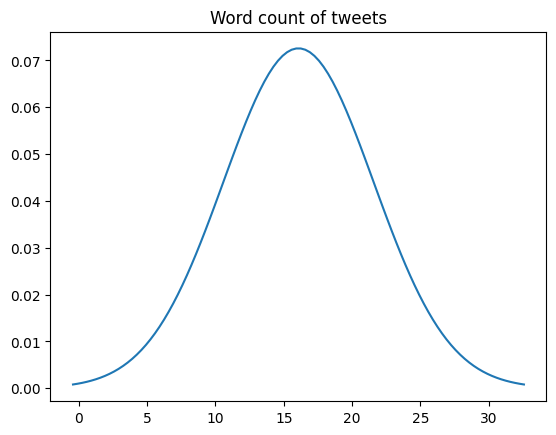

0.15496035903084263

In [26]:
mu = train_df['word_count'].mean()
sigma = train_df['word_count'].std()

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title("Word count of tweets")
plt.show()

# Skewness is quite low so normal distribution is quite accurate. 
train_df['word_count'].skew()


#### Word Length

In [27]:
train_df['avg_word'].mean()
train_df['avg_word'].std()
train_df['avg_word'].skew() # Skewness here is quite high

7.025015232940537

#### Question Marks

question_marks
0     27688
1      1491
2       233
3        61
4        40
5        10
6         6
12        1
Name: count, dtype: int64

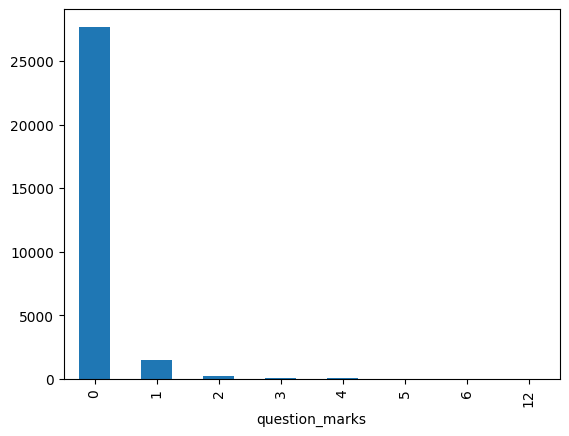

In [28]:
train_df['question_marks'].value_counts().sort_index().plot(kind="bar")
train_df['question_marks'].value_counts().sort_index()

#### Exclamation Mark

exclamation_marks
0     22411
1      4349
2      1496
3       713
4       281
5       105
6        76
7        33
8        23
9        13
10        5
11        4
12        3
13        6
14        5
15        3
16        2
19        1
58        1
Name: count, dtype: int64

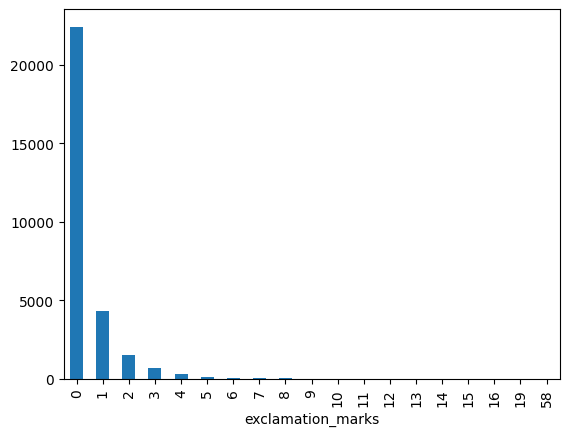

In [29]:
train_df['exclamation_marks'].value_counts().sort_index().plot(kind="bar")
train_df['exclamation_marks'].value_counts().sort_index()

## Model Creation